## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [17]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time
from collections import defaultdict
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [6]:
if not os.path.isdir('UCI HAR Dataset'):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O temp.zip && unzip temp.zip && rm temp.zip

--2022-12-14 01:43:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘temp.zip’

temp.zip            100%[===================>]  58.17M  18.2MB/s    in 4.1s    

2022-12-14 01:43:35 (14.3 MB/s) - ‘temp.zip’ saved [60999314/60999314]

Archive:  temp.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_i

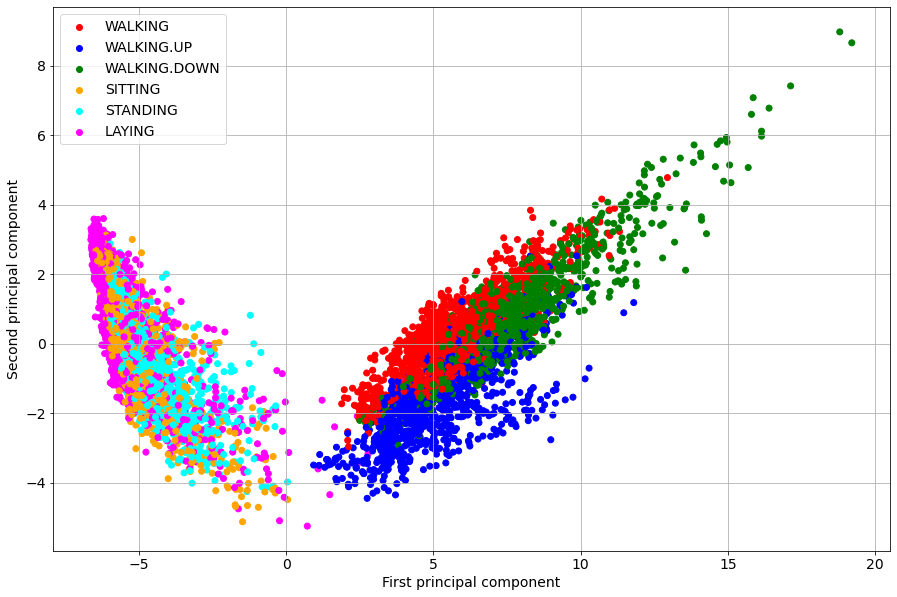

In [7]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [8]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [9]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [10]:
from torch.utils.data import Dataset, DataLoader
import torch


train_mean = X_train.mean(axis=(0, 1))
train_std = X_train.std(axis=(0, 1))

class DatasetHAR(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy((data - train_mean) / train_std).permute(0,2,1).float()
        self.labels = torch.from_numpy(labels).flatten().long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [11]:
BATCH_SIZE = 512

In [12]:
train_dataset = DatasetHAR(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = DatasetHAR(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
from IPython.display import clear_output

class Runner:
    """Runner for experiments with supervised model."""
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.checkpoint_name = checkpoint_name
        
        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0
        self._set_events()
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }
    
    def _set_events(self):
        """
        Additional method to initialize variables, which may store logging and evaluation info.
        The implementation below is extremely simple and only provided to help monitor performance.
        """
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }
    
    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)
    
    def forward(self, img_batch, **kwargs):
        """
        Forward method for your Runner.
        Should not be called directly outside your Runner.
        In simple case, this method should only implement your model forward pass.
        It should also return the model predictions and/or other meta info.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
            **kwargs: additional parameters to pass to the model.
        """
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output
    
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        raise NotImplementedError("To be implemented")
    
    def output_log(self):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Implement this method for logging purposes.
        """
        raise NotImplementedError("To be implemented")
    
    def _run_batch(self, batch):
        """
        Runs batch of data through the model, performing forward pass.
        This implementation performs data passing to necessary device and is adapted to the default pyTorch DataLoader.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)
        
        # move data to target device
        X_batch = X_batch.to(self.device)
        
        # run the batch through the model
        self.output = self.forward(X_batch)
    
    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        """
        Method that runs one epoch of the training process.
        
        Args:
            loader (DataLoader): data loader to iterate
            train_phase (bool): boolean value to determine if this is the training phase.
                Changes behavior for dropout, batch normalization, etc.
        """
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)
        
        _phase_description = 'Training' if train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            
            # forward pass through the model using preset device
            self._run_batch(batch)
            
            # train on batch: compute loss and gradients
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)
            
            # compute backward pass if training phase
            # reminder: don't forget the optimizer step and zeroing the grads
            if train_phase:
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
        
        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))
        
        if output_log:
            self.output_log(**kwargs)
    
    def train(self, train_loader, val_loader, n_epochs, model=None, opt=None, **kwargs):
        """
        Training process method, that runs for n_epochs over train_loader and performs validation using val_loader.
        
        Args:
            train_loader (DataLoader): training set data loader to iterate over
            val_loader (DataLoader): validation set data loader to iterate over
            n_epochs (int): epoch number to train for
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self.opt = (opt or self.opt)
        self.model = (model or self.model)
        
        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")
            
            # training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)
            
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")
            
            # validation part
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()
    
    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        """
        Validation process method, that estimates the performance of self.model on validation data in loader.
        
        Args:
            loader (DataLoader): validation set data loader to iterate over
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics

In [183]:
from sklearn.metrics import accuracy_score

class CNNRunner(Runner):
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        X_batch, label_batch = batch
        label_batch = label_batch.to(device)
        
        logit_batch = self.output['logits']
        
        # compute loss funciton
        loss = F.cross_entropy(logit_batch, label_batch)
        
        scores = F.softmax(logit_batch, 1).detach().cpu().numpy()
        labels = label_batch.detach().cpu().numpy().ravel().tolist()
        
        # log some info
        self.events[self._phase_name]['loss'].append(loss.detach().cpu().numpy())
        self.events[self._phase_name]['scores'].extend(scores)
        self.events[self._phase_name]['labels'].extend(labels)
        
        return loss
    
    def save_checkpoint(self):
        val_accuracy = self.metrics['accuracy']
        # save checkpoint of the best model to disk
        if val_accuracy > self._top_val_accuracy and self.checkpoint_name is not None:
            self._top_val_accuracy = val_accuracy
            with open(self.checkpoint_name, 'wb') as checkpoint_file:
                torch.save(self.model, checkpoint_file)
    
    def output_log(self, **kwargs):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Let's have a fancy code for classification metrics calculation.
        """
        scores = np.array(self.events[self._phase_name]['scores'])
        labels = np.array(self.events[self._phase_name]['labels'])
        
        assert len(labels) > 0, print('Label list is empty')
        assert len(scores) > 0, print('Score list is empty')
        assert len(labels) == len(scores), print('Label and score lists are of different size')
        
        visualize = kwargs.get('visualize', False)
        if visualize:
            clear_output()
        
        self.metrics = {
            "loss": np.mean(self.events[self._phase_name]['loss']),
            "accuracy": accuracy_score(labels, np.argmax(scores, axis=1)),
        }
        print(f'{self._phase_name}: ', end='')
        print(' | '.join([f'{k}: {v:.4f}' for k, v in self.metrics.items()]))
        
        self.save_checkpoint() 
        
        if visualize:
            # tensorboard for the poor
            fig = plt.figure(figsize=(15,5))
            
            plt.plot(self.log_dict['train'], color='b', label='train')
            plt.plot(self.log_dict['val'], color='c', label='val')
            plt.legend()
            plt.title('Train/val loss.')
            
            plt.show()

In [22]:
class Model(nn.Module):
    def __init__(self, input_channels=n_input, num_classes=n_classes):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_input, 18, 2),
            nn.MaxPool1d(2, 2),
            nn.BatchNorm1d(18),
            nn.ReLU(),

            nn.Conv1d(18, 36, 2),
            nn.MaxPool1d(2, 2),
            nn.BatchNorm1d(36),
            nn.ReLU(),

            nn.Conv1d(36, 72, 2),
            nn.MaxPool1d(2, 2),
            nn.BatchNorm1d(72),
            nn.ReLU(),

            nn.Conv1d(72, 144, 2),
            nn.MaxPool1d(2, 2),
            nn.BatchNorm1d(144),
            nn.ReLU(),

            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(144, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes, bias=False)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [23]:
summary(Model().to(device), (n_input, n_steps))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 18, 127]             342
         MaxPool1d-2               [-1, 18, 63]               0
       BatchNorm1d-3               [-1, 18, 63]              36
              ReLU-4               [-1, 18, 63]               0
            Conv1d-5               [-1, 36, 62]           1,332
         MaxPool1d-6               [-1, 36, 31]               0
       BatchNorm1d-7               [-1, 36, 31]              72
              ReLU-8               [-1, 36, 31]               0
            Conv1d-9               [-1, 72, 30]           5,256
        MaxPool1d-10               [-1, 72, 15]               0
      BatchNorm1d-11               [-1, 72, 15]             144
             ReLU-12               [-1, 72, 15]               0
           Conv1d-13              [-1, 144, 14]          20,880
        MaxPool1d-14               [-1,

In [27]:
model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
opt.zero_grad()
ckpt_name = 'model.ckpt'
runner = CNNRunner(model, opt, device, ckpt_name)

val: loss: 0.2239 | accuracy: 0.9382


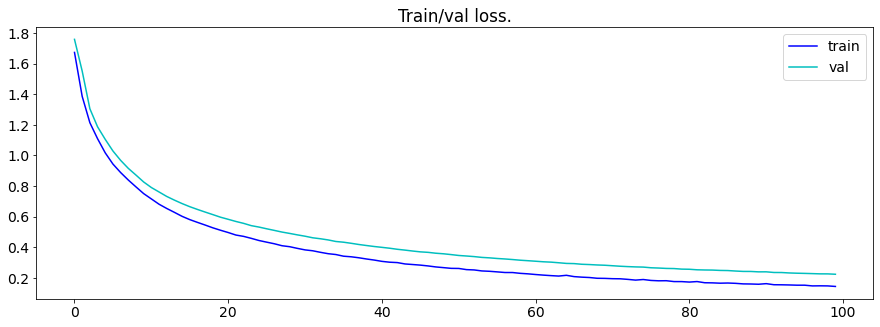

In [28]:
runner.train(train_loader, test_loader, n_epochs=100, visualize=True)

In [30]:
best_model = None
with open('model.ckpt', 'rb') as f:
    best_model = torch.load(f)

test_stats = runner.validate(test_loader, best_model, phase_name='test')
assert test_stats['accuracy'] > 0.91

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

test: loss: 0.2239 | accuracy: 0.9382


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/

**Вообще не думал, взял эту статью и добавил BachNormalization, в принципе все. Но у меня вопрос: почему мы делаем bias=false в последнем fcl?**


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
!unzip /content/drive/MyDrive/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/46/37.jpeg   
  inflating: __MACOSX/data/train/46/._37.jpeg  
  inflating: data/train/46/138.jpeg  
  inflating: __MACOSX/data/train/46/._138.jpeg  
  inflating: data/train/46/60.jpeg   
  inflating: __MACOSX/data/train/46/._60.jpeg  
  inflating: data/train/46/99.jpeg   
  inflating: __MACOSX/data/train/46/._99.jpeg  
  inflating: data/train/46/76.jpeg   
  inflating: __MACOSX/data/train/46/._76.jpeg  
  inflating: data/train/46/21.jpeg   
  inflating: __MACOSX/data/train/46/._21.jpeg  
  inflating: data/train/46/102.jpeg  
  inflating: __MACOSX/data/train/46/._102.jpeg  
  inflating: data/train/46/143.jpeg  
  inflating: __MACOSX/data/train/46/._143.jpeg  
  inflating: data/train/46/114.jpeg  
  inflating: __MACOSX/data/train/46/._114.jpeg  
  inflating: data/train/46/34.jpeg   
  inflating: __MACOSX/data/train/46/._34.jpeg  
  inflating: data/train/46/63.jpeg   
  inflating: __MACOSX/data/train/46/._63.jpeg  

In [55]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128

In [170]:
transformer_train = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomApply([transforms.RandomRotation(degrees=20)], p=0.25),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])


transformer_val = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [127]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import splitfolders # or import splitfolders
input_folder = "/content/data/train"
output = "/content/data_splitted"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.75, .25))

Copying files: 7166 files [00:02, 3178.29 files/s]


In [171]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(output, 'train'), transform=transformer_train)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(output, 'val'), transform=transformer_val)

In [172]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=0)

val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=0)

In [173]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(train_std * batch_image_ndarray + train_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

sdf


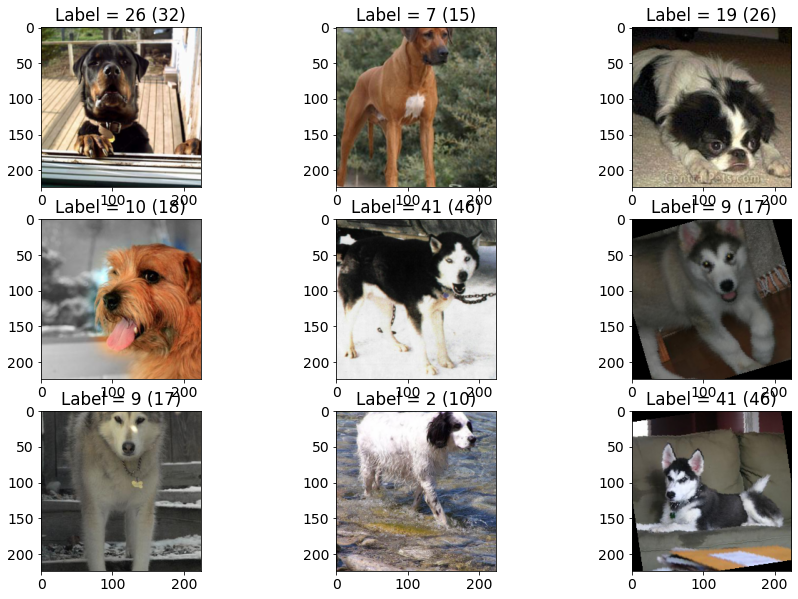

In [174]:
plot_from_batch_generator(train_batch_gen)

In [77]:
model_resnet50 = torchvision.models.resnet50(weights='DEFAULT')

In [78]:
num_feat = model_resnet50.fc.in_features

In [79]:
for name, p in model_resnet50.named_parameters():
    if not name.startswith('fc') and not name.startswith('layer4'):
        p.requires_grad_(False)

In [80]:
model_resnet50.fc = nn.Linear(num_feat, 50)

# Use available device for calculations
model_resnet50 = model_resnet50.to(device)

In [81]:
summary(model_resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [186]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet50.fc.parameters(), lr=1e-3)
ckpt_name_resnet50='model_resnet50_finetune.ckpt'

runner_finetune = CNNRunner(model_resnet50, opt_resnet, device, ckpt_name_resnet50)

val: loss: 0.1895 | accuracy: 0.9492


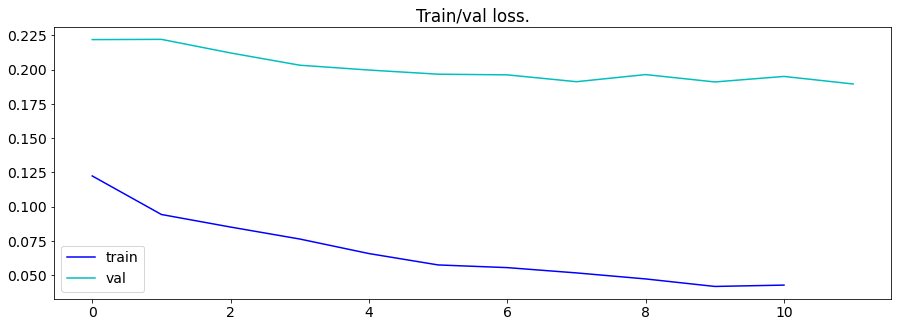

In [229]:
runner_finetune.train(train_batch_gen, val_batch_gen, n_epochs=10, visualize=True)

In [230]:
best_model_resnet50 = torch.load(open(ckpt_name_resnet50, 'rb'))

In [231]:
val_stats = runner_finetune.validate(val_batch_gen, best_model_resnet50, 'val')

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

val: loss: 0.1895 | accuracy: 0.9492


In [190]:
import pandas as pd
from skimage.io import imread

In [233]:
val_batch_gen.dataset.class_to_idx == train_batch_gen.dataset.class_to_idx

True

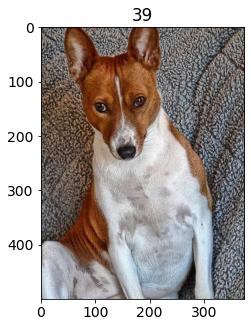

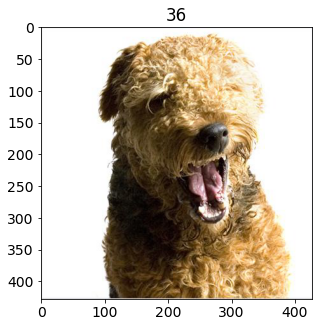

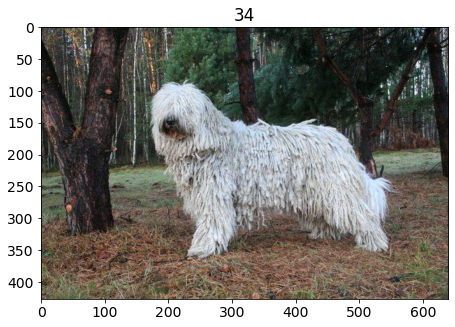

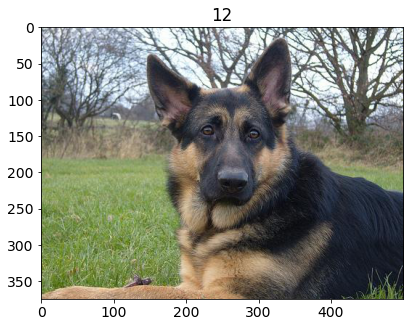

In [235]:
images = []
labels = []
for i, image_path in enumerate(os.listdir('/content/data/test')):
    trans = transforms.ToPILImage()
    image = trans(imread(f'/content/data/test/{image_path}'))
    tensor = transformer_val(image)[None, :, :, :].to(device)
    images.append(image_path.split('.')[0])
    with torch.no_grad():
        max_logit = best_model_resnet50(tensor).detach().cpu().numpy()[0].argmax()
        labels.append(val_batch_gen.dataset.classes[max_logit])
    if i % 500 == 0:
        plt.figure(figsize=(10,5))
        plt.imshow(image)
        plt.title(labels[-1])
        plt.show()

In [236]:
import pandas as pd

In [237]:
pd.DataFrame(data={
    'image_name': images,
    'label': labels,
}).to_csv('predict.csv', index=False)

**Провел один эксперимент с претюниной resnet50,точность на валидации составила 95%, конечно на тесте может быть меньше, но что поделать. Долго не понимал, почему результаты на тесте очень странный в итоге узнал, ImageFolder изменяет labels**